<a href="https://colab.research.google.com/github/salmankhanday/Deep-ResNet-Based-classification-of-Long-Tailed-Data-with-Renyi-Entropy-as-Loss-Function/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jiequancui/ResLT.git

Cloning into 'ResLT'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 154 (delta 62), reused 90 (delta 29), pack-reused 0
Receiving objects: 100% (154/154), 13.14 MiB | 6.87 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
import os 
os.chdir("/content/ResLT/CIFAR") 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.datasets as datasets

import numpy as np
from PIL import Image
import random
import math
import matplotlib.pyplot as plt

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10
    data_path="/mnt/proj56/jqcui/Data/cifar10"
    def __init__(self, root=None, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False, class_balance=False):
        root=self.data_path
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

        self.class_balance = class_balance
        if class_balance:
           self.class_data=[ [] for i in range(self.cls_num) ]
           for i in range(len(self.targets)):
              self.class_data[self.targets[i]].append(i)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        print(len(new_targets))
       
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def __getitem__(self, index):
          if self.class_balance:
             sample_class = random.randint(0, self.cls_num - 1)
             index = random.choice(self.class_data[sample_class])
             img, target = self.data[index], sample_class 
          else:
             img, target = self.data[index], self.targets[index]
          img = Image.fromarray(img)
          if self.transform is not None:
            img = self.transform(img)

          return img, target 


class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100
    data_path="/mnt/proj56/jqcui/Data/cifar100"


class CIFAR10V2(object):
    def __init__(self, batch_size=128, class_balance=False, imb_factor=None):
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        normalize = transforms.Normalize(mean, std)
        transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
        trainset = IMBALANCECIFAR10(root="/mnt/proj56/jqcui/Data/cifar10", train=True, transform=transform_train, download=False, imb_factor=imb_factor, class_balance=class_balance)
        testset = datasets.CIFAR10(root='/mnt/proj56/jqcui/Data/cifar10', train=False, transform=transform_test, download=False)

        self.train = torch.utils.data.DataLoader(
            trainset,
            batch_size = batch_size, shuffle = True,
            num_workers = 8, pin_memory = True, drop_last=True)

        self.test = torch.utils.data.DataLoader(
            testset,
            batch_size = batch_size, shuffle = False,
            num_workers = 4, pin_memory = True)

class CIFAR10V2_auto(object):
    def __init__(self, batch_size=128, class_balance=False, imb_factor=None):
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        normalize = transforms.Normalize(mean, std)
        transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                CIFAR10Policy(),
                transforms.ToTensor(),
                normalize,
            ])
        transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
        trainset = IMBALANCECIFAR10(root="/mnt/proj56/jqcui/Data/cifar10", train=True, transform=transform_train, download=False, imb_factor=imb_factor, class_balance=class_balance)
        testset = datasets.CIFAR10(root='/mnt/proj56/jqcui/Data/cifar10', train=False, transform=transform_test, download=False)

        self.train = torch.utils.data.DataLoader(
            trainset,
            batch_size = batch_size, shuffle = True,
            num_workers = 8, pin_memory = True, drop_last=True)

        self.test = torch.utils.data.DataLoader(
            testset,
            batch_size = batch_size, shuffle = False,
            num_workers = 4, pin_memory = True)

class CIFAR100V2(object):
    def __init__(self, batch_size=128, class_balance=False, dual_sampler=False, imb_factor=None):
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        normalize = transforms.Normalize(mean, std)
        transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
        trainset = IMBALANCECIFAR100(root='/mnt/proj56/jqcui/Data/cifar100', train=True, transform=transform_train, download=False, imb_factor=imb_factor, class_balance=class_balance)
        testset = datasets.CIFAR100(root='/mnt/proj56/jqcui/Data/cifar100', train=False, transform=transform_test, download=False)

        self.train = torch.utils.data.DataLoader(
            trainset,
            batch_size = batch_size, shuffle = True,
            num_workers = 8, pin_memory = True, drop_last=True)

        self.test = torch.utils.data.DataLoader(
            testset,
            batch_size = batch_size, shuffle = False,
            num_workers = 4, pin_memory = True)

class CIFAR100V2_auto(object):
    def __init__(self, batch_size=128, class_balance=False, dual_sampler=False, imb_factor=None):
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        normalize = transforms.Normalize(mean, std)
        transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                CIFAR10Policy(),
                transforms.ToTensor(),
                normalize,
            ])
        transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
        trainset = IMBALANCECIFAR100(root='/mnt/proj56/jqcui/Data/cifar100', train=True, transform=transform_train, download=False, imb_factor=imb_factor, class_balance=class_balance)
        testset = datasets.CIFAR100(root='/mnt/proj56/jqcui/Data/cifar100', train=False, transform=transform_test, download=False)

        self.train = torch.utils.data.DataLoader(
            trainset,
            batch_size = batch_size, shuffle = True,
            num_workers = 8, pin_memory = True, drop_last=True)

        self.test = torch.utils.data.DataLoader(
            testset,
            batch_size = batch_size, shuffle = False,
            num_workers = 4, pin_memory = True)


if __name__ == '__main__':
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = IMBALANCECIFAR10(root='/mnt/proj56/jqcui/Data/cifar10', train=True,
                    download=True, transform=transform)
    trainloader = iter(trainset)
    data, label = next(trainloader)

100%|██████████| 170498071/170498071 [00:10<00:00, 15738171.72it/s]


Extracting /mnt/proj56/jqcui/Data/cifar10/cifar-10-python.tar.gz to /mnt/proj56/jqcui/Data/cifar10
12406


In [ ]:
import torch.nn as nn

class RenyiEntropyLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(RenyiEntropyLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, input, target):
        n = input.size()[0]
        log_prob = nn.functional.log_softmax(input, dim=1)
        y_onehot = torch.zeros_like(log_prob)
        y_onehot.scatter_(1, target.view(-1, 1), 1)
        
        # compute Renyi entropy loss
        loss = (1/(1-self.alpha))*torch.log(torch.sum(torch.exp(self.alpha*log_prob)*y_onehot, dim=1)) + \
               (1/self.alpha)*torch.log(torch.sum(torch.exp((1-self.alpha)*log_prob)*(1-y_onehot), dim=1))
        return -torch.mean(loss)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import math

BN=nn.BatchNorm2d

__all__ = [
    "ResNet",
    "resnet20",
    "resnet32",
    "resnet44",
    "resnet56",
    "resnet110",
    "resnet1202",
]


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, groups=1, option="A", arrange=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups
        )
        self.bn1 = BN(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
        )
        self.bn2 = BN(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    BN(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, scale=1, groups=1, nc=[16, 32, 64], arrange=[2,1,1]):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = nc[0] * scale
        self.arrange=arrange

        self.conv1 = nn.Conv2d(3, nc[0] * scale, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = BN(nc[0] * scale)
        self.layer1 = self._make_layer(block, nc[0] * scale , num_blocks[0], stride=1, groups=groups)
        self.layer2 = self._make_layer(block, nc[1] * scale , num_blocks[1], stride=2, groups=groups)
        self.layer3 = self._make_layer(block, nc[2] * scale , num_blocks[2], stride=2, groups=groups)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, groups=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, groups=groups, arrange=self.arrange))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

class ResLTResNet32(nn.Module):
      def __init__(self, num_classes=10, scale=1):
          super(ResLTResNet32, self).__init__()
          nc=[16, 32, 64]
          nc=[c * scale for c in nc]
          self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
          self.linear = nn.Linear(nc[2], num_classes)
          self.model = ResNet_Cifar(BasicBlock, [5, 5, 5], num_classes=num_classes, nc=nc)

          # 1x1 conv can be replaced with more light-weight bn layer
          self.BNH = nn.BatchNorm2d(nc[2])
          self.BNM = nn.BatchNorm2d(nc[2])
          self.BNT = nn.BatchNorm2d(nc[2])

      def forward(self, x):
          out = self.model(x)
          head_fs, medium_fs, tail_fs=self.BNH(out), self.BNM(out), self.BNT(out) 

          fs = torch.cat((head_fs, medium_fs, tail_fs),dim=0)
          logits = self.linear(self.avgpool(fs).view(fs.size(0),-1))
          c = logits.size(0) // 3
          return  logits[:c,:], logits[c:c*2,:], logits[c*2:,:]

In [ ]:
class Args:
  pass

In [ ]:
import argparse
import torch
import torch.nn as nn
import sys
import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from networks import nets
from datasets import dataset
import time
import math

model_names=['ResLTResNet32']

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
args=Args()
args.mark="*"
args.epochs=200
args.arch='ResLTResNet32'
args.start_epoch=1
args.lr=0.1
args.momentum=0.9
args.weight_decay=5e-4
args.print_freq=100
args.resume=''
args.finetune=''
args.beta=1.0
args.imb_factor=1.0
args.scale=1
args.cosine=False
args.Ti=10
args.Ti_mul=2
args.lr_min=1e-5
args.lr_max=0.1
args.dataset='CIFAR10V2'
args.num_classes=10
args.batch_size=128
args.seed=42

#parser.add_argument('-mark',type=str,default='')
#parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet50', choices=model_names, help='model architecture: ' + ' | '.join(model_names) + ' (default: resnet50)')
#parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
#parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
#parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
#parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
#parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float, metavar='W', help='weight decay (default: 1e-4)')
#parser.add_argument('--print-freq', '-p', default=100, type=int, metavar='N', help='print frequency (default: 10)')
#parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
#parser.add_argument('--finetune', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
#parser.add_argument('--beta', default=1.0, type=float)
#parser.add_argument('--imb_factor', default=None, type=float)
#parser.add_argument('--scale', default=1, type=int)

###cosine
#parser.add_argument('-cosine', default=False, type=bool)
#parser.add_argument('-Ti', default=10, type=int)
#parser.add_argument('-Ti_mul', default=2, type=int)
#parser.add_argument('-lr_min', default=1e-5, type=float)
#parser.add_argument('-lr_max', default=0.1, type=float)
###dataset
#parser.add_argument('-dataset',default='CIFAR10', type=str)
#parser.add_argument('-num_classes',default=10, type=int)
#parser.add_argument('-b', '--batch-size', default=128, type=int, metavar='N', help='mini-batch size (default: 256)')

### random seed
#parser.add_argument('-seed',default=None, type=int)


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam1 = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = lam1 * x + (1-lam1) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam1

def mixup_criterion(criterion, pred, y_a, y_b, lam1):
    return lam1 * criterion(pred, y_a) + (1-lam1) * criterion(pred, y_b)

def crossEntropy(softmax, logit, label, weight):
    target = F.one_hot(label, args.num_classes)
    loss = - (weight * (target * torch.log(softmax(logit)+1e-7)).sum(dim=1)).sum()
    return loss

def Train():
    os.makedirs("Logs/CIFAR10", exist_ok=True)
    os.makedirs("checkpoints/CIFAR10/", exist_ok=True)

    ### SEED
    if args.seed is not None:
       SEED=args.seed
       torch.manual_seed(SEED)
       torch.cuda.manual_seed(SEED)
       np.random.seed(SEED)
       torch.backends.cudnn.deterministic=True

    #####
    data=getattr(dataset,args.dataset)(batch_size=args.batch_size, imb_factor=args.imb_factor)
   
    #####
    model=getattr(nets,args.arch)(num_classes=args.num_classes, scale=args.scale)
    model = nn.DataParallel(model)
    model=model.cuda()

    optimizer=torch.optim.SGD(model.parameters(), lr=args.lr_max if args.cosine else args.lr, momentum=args.momentum,weight_decay=args.weight_decay, nesterov=True)
    #ce=torch.nn.CrossEntropyLoss().cuda()
    mse=torch.nn.MSELoss().cuda()
    kl=nn.KLDivLoss(size_average=False)
    softmax=nn.Softmax(dim=1)
    ce = RenyiEntropyLoss(alpha=0.4).cuda()
    ##### lr schedule cosine
    Ti=args.Ti
    Ti_mul=args.Ti_mul
    lr_min=args.lr_min
    lr_max=args.lr_max
    last_restart_epoch=0
    ##### cosine
    def lr_schedule_cosine(epoch,Ti,last_restart_epoch):
        T_cur=epoch-last_restart_epoch
        if T_cur<Ti:
           rate=T_cur/Ti*3.1415926
           lr=lr_min+0.5*(lr_max-lr_min)*(1.0+math.cos(rate))
        else:
           last_restart_epoch=epoch
           Ti=int(Ti*Ti_mul+0.5)
           T_cur=epoch-last_restart_epoch
           rate=T_cur/Ti*3.1415926
           lr=lr_min+0.5*(lr_max-lr_min)*(1.0+math.cos(rate))
        for param_group in optimizer.param_groups:
                param_group['lr']=lr
        return lr,Ti,last_restart_epoch

    ##### lr multi step schedule
    step=[160, 180, 200]
    def lr_schedule_multistep(epoch):
        if epoch<5:
           factor=(epoch+1)/5.0
           lr= args.lr * ( 1/3.0 *(1-factor) + factor )
        elif epoch<160 * 1 :
              lr=args.lr
        elif epoch<180 * 1 :
              lr=args.lr * 0.1
        elif epoch<200 * 1 :
              lr=args.lr * 0.1 * 0.1
        for param_group in optimizer.param_groups:
                param_group['lr']=lr
        return lr

    #####Train
    start_epoch=0
    end_epoch=args.epochs
    best_acc=0.0
    for epoch in range(start_epoch,end_epoch):
        #####adjust learning rate every epoch begining
        if args.cosine:
           lr,Ti,last_restart_epoch=lr_schedule_cosine(epoch,Ti,last_restart_epoch)
        else:
           lr=lr_schedule_multistep(epoch)
        #####

        model.train()
        train_loss=0.0
        total=0.0
        correct=0.0
        num=0
        for i,(inputs,target) in enumerate(data.train):
            input, target = inputs.cuda(),target.cuda()
            logitH, logitM, logitT = model(input)
            ### ResLT 
            labelH = F.one_hot(target, args.num_classes).sum(dim=1)
            labelM = F.one_hot(target, args.num_classes)[:,2:10].sum(dim=1)
            labelT = F.one_hot(target, args.num_classes)[:,4:10].sum(dim=1)
            loss_ice = (crossEntropy(softmax, logitH, target, labelH) + crossEntropy(softmax, logitM, target, labelM) \
                       + crossEntropy(softmax, logitT, target, labelT)) / (labelH.sum() + labelM.sum() + labelT.sum())

            logit = (logitH + logitM + logitT)
            loss_fce=ce(logit,target)
            loss = loss_ice * args.beta + (1-args.beta) * loss_fce

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            _,predicted = logit.max(1)
            total += target.size(0)
            num+=1
            correct += predicted.eq(target).sum().item()
            if i % args.print_freq == 0:
                acc_n=logit.max(dim=1)[1].eq(target).sum().item()
                open("Logs/CIFAR10/"+args.mark+".log","a+").write('Train loss %.5f  loss_ice %.5f loss_fce %.5f acc_n %.5f lr %.5f\n'%(loss.item(), loss_ice.item(), loss_fce.item(), acc_n/input.size(0), lr))
        open("Logs/CIFAR10/"+args.mark+".log","a+").write("Train epoch=%d loss=%.5f  acc=%.5f\n"%(epoch,train_loss/num,correct/total))

        model.eval()
        test_loss=0.0
        total=0.0
        class_num=torch.zeros(args.num_classes).cuda()
        correct=torch.zeros(args.num_classes).cuda()
        num=0
        for i,(inputs,target) in enumerate(data.test):
            input, target = inputs.cuda(),target.cuda()
            logitH, logitM, logitT= model(input)
            logit = logitH  + logitM + logitT
            loss=ce(logit, target)
            test_loss+=loss.item()
            _,predicted = logit.max(1)
            total += target.size(0)
            num+=1
            target_one_hot=F.one_hot(target,args.num_classes)
            predict_one_hot=F.one_hot(predicted,args.num_classes)
            class_num=class_num + target_one_hot.sum(dim=0).to(torch.float)
            correct=correct + (target_one_hot + predict_one_hot==2).sum(dim=0).to(torch.float)

        acc=correct.sum()/total
        acc_classes=correct/class_num
        head_acc=acc_classes[:3].mean()
        medium_acc=acc_classes[3:6].mean()
        tail_acc=acc_classes[6:10].mean()

        if best_acc<acc:
           best_acc=acc
           torch.save(model.state_dict(),"checkpoints/CIFAR10/"+args.mark+"_"+"best.pth")

        
        open("Logs/CIFAR10/"+args.mark+".log","a+").write("Test epoch=%d loss=%.5f  acc=%.5f best_acc=%.5f\n"%(epoch,test_loss/num,correct.sum()/total, best_acc))
        open("Logs/CIFAR10/"+args.mark+".log","a+").write("Test "+str(correct/class_num)+"\n") 
        open("Logs/CIFAR10/"+args.mark+".log","a+").write("Test head acc:"+str(head_acc)+" medium acc "+str(medium_acc)+" tail acc "+str(tail_acc)+"\n")

 
#args = parser.parse_args()
Train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/_

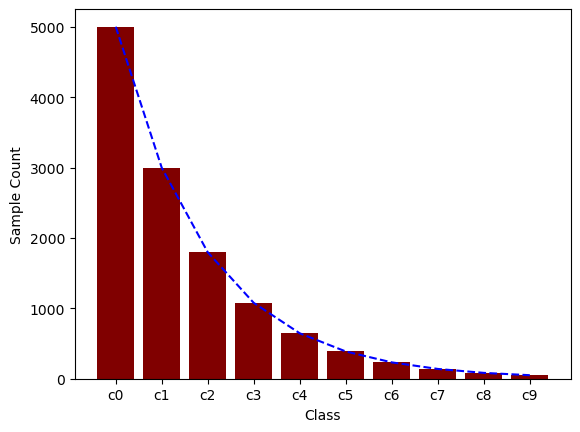

In [ ]:
classes=["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
count=[5000,2997,1796,1077,645,387,232,139,83,50]
plt.bar(classes,count,color='maroon')
plt.plot(classes,count,color="blue",linestyle="dashed")
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.savefig("cifar10imb_shape.png")